In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import torch
from einops import rearrange
from random import randint
from dataset import ImageDataset
from vit_trainer import VitTrainer

import matplotlib.pyplot as plt
import numpy as np

from utils import permute_image, topk_acc

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [40]:
vit_trainer = VitTrainer.load_from_checkpoint('logs/kf2x907t-484-ep78.ckpt')
cfg = vit_trainer.cfg

vit = vit_trainer.model.to(device)
vit = vit.eval()
dataset = ImageDataset(cfg.data_dir, cfg.image_paths_pkl)

Selected index: 21895


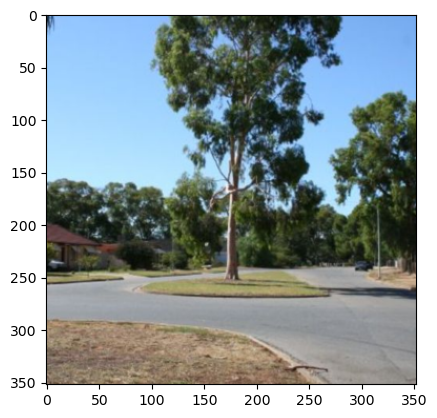

In [123]:
idx = randint(0, len(dataset) - 1)
print(f'Selected index: {idx}')
img = vit_trainer.resize_image(dataset[idx])

plt.imshow(img.permute(1, 2, 0))
plt.show()

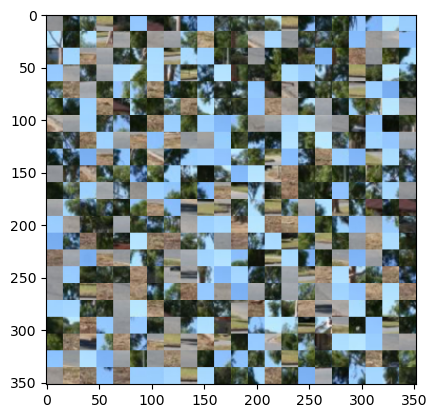

In [124]:
p_img, _ = permute_image(img, patch_size=cfg.patch_size)
plt.imshow(p_img.permute(1, 2, 0))
plt.show()

In [125]:
with torch.no_grad():
    x = p_img.unsqueeze(0).to(device)
    x = vit_trainer.image_transforms(x)
    y = vit(x)

In [129]:
gt = vit_trainer.gt_single.expand(y.size(0), -1)
t1_acc = topk_acc(y, gt, k=1)
t5_acc = topk_acc(y, gt, k=5)
print(f'Top-1 accuracy: {t1_acc:.4f}')
print(f'Top-5 accuracy: {t5_acc:.4f}')

Top-1 accuracy: 0.9979
Top-5 accuracy: 1.0000


In [130]:
n_side = cfg.crop_image_to_px // cfg.patch_size
pred_perm = y.squeeze().argmax(dim=-1).cpu().numpy()
pred_row = pred_perm // n_side
pred_col = pred_perm % n_side

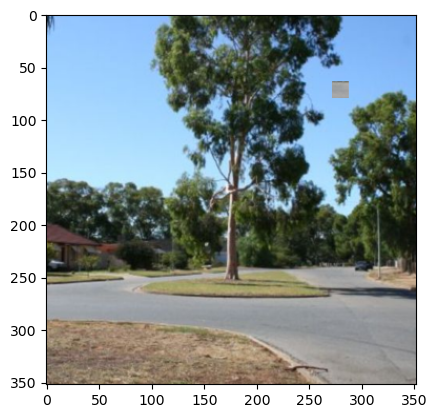

In [131]:
recon_image, _ = permute_image(img, cfg.patch_size, pred_perm)
plt.imshow(recon_image.permute(1, 2, 0))
plt.show()

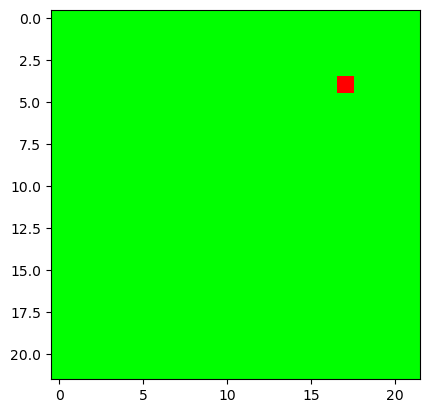

In [132]:
# Visualize the top-1 error locations
# If a patch position is predicted wrong, it will be colored red
# Otherwise, it will be colored green.


def visualize_top1_error(recon_image, pred_perm, gt_perm):
    gt_perm = gt_perm.cpu().numpy().squeeze()
    n_side = cfg.crop_image_to_px // cfg.patch_size
    errors = np.where(pred_perm != gt_perm)[0]

    r = errors // n_side
    c = errors % n_side

    overlay = np.zeros((n_side, n_side, 3), dtype=np.float32)
    overlay[:] = [0, 1, 0]
    overlay[r, c] = [1, 0, 0]

    # Blend the overlay with the image
    # recon_image = recon_image.permute(1, 2, 0).cpu().numpy()

    plt.imshow(overlay)
    plt.show()


visualize_top1_error(recon_image, pred_perm, gt)